# CNN

## 1. Imports

### 1.1 Setup for Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/data

In [ ]:
ls

### 1.2 Install Depedencies

In [ ]:
#install dependencies
# !pip install -r requirements.txt

In [ ]:
import os
import copy
import glob
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms,models
from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import pandas as pd
import wandb
import time
from datetime import datetime

### 1.2 Global Variables

In [ ]:
EPOCHS = 30
CLASSES = 7
BATCH_SIZE = 64
NUM_WORKERS = 12 # change based on specification of computer
LEARNING_RATE = 0.001

## 2. Load Data and Split

In [ ]:
#directories
rgbDir = ['RGB','RgbAug']
thermalDir = ['Thermal','ThermalAug']

### 2.1 Single Modality

In [ ]:
def loadDataSingleModality(modalDir):
    '''
    Loads and processes data from a single modality (either RGB or Thermal).
    Args:
        modalDir (list): List containing two directory paths - first for raw images, second for augmented images.
    Returns:
        pairedFiles (list): List of all image file paths.
        tensorLabels (torch.Tensor): Tensor of integer-encoded labels corresponding to the images.
    '''

    #get list of files in the directory and combine them
    pairedFiles = []
    for data in modalDir:
        pairedFiles.extend(glob.glob(os.path.join(data, "*")))
    pairedFiles = sorted(pairedFiles)

    print(f'Total files: {len(pairedFiles)}')


    #get the labels from the filenames
    SMLabels = [os.path.basename(f).split('_')[1] for f in pairedFiles] #1 = emotion label

    #convert labels to integer
    le = preprocessing.LabelEncoder()
    intLabels = le.fit_transform(SMLabels)
    #convert targets to tensor
    tensorLabels = torch.as_tensor(intLabels)
    #class names
    classNames = le.classes_

    print(f'Data arranged as: {tensorLabels}')
    print(f'\nSample output:\nFile: {pairedFiles[0]}\nLabel: {SMLabels[0]}\n')

    return pairedFiles, tensorLabels, classNames


## For single modality testing (uaing raw and augmented data together)

#change this to test either thermal or rgb
modalDir = rgbDir

#Call function to load data
pairedFiles, tensorLabels, classNames = loadDataSingleModality(modalDir)

#for saving results later
if modalDir == rgbDir:
    savingLabel = "RGB"
else:
    savingLabel = "Thermal"

Total files: 19287
Data arranged as: tensor([0, 0, 0,  ..., 6, 6, 6])

Sample output:
File: RGB/R_Angry_10_KTFE.jpg
Label: Angry



### 2.2 Multi Modality

In [ ]:
def loadDataMultiModality(rgbDir,thermalDir):
    '''
    Loads and processes data from both RGB and Thermal modalities.
    Args:
        rgbDir (list): List containing two directory paths for RGB images - first for raw images, second for augmented images.
        thermalDir (list): List containing two directory paths for Thermal images - first for raw images, second for augmented images.
    Returns:
        pairedFiles (list): List of tuples, each containing a pair of (RGB image path, Thermal image path).
        tensorLabels (torch.Tensor): Tensor of integer-encoded labels corresponding to the images.
    '''


    #get list of files in the directory and combine them
    rgbFiles = []
    thermalFiles = []
    for data in rgbDir:
        rgbFiles.extend(glob.glob(os.path.join(data, "*")))
    for data in thermalDir:
        thermalFiles.extend(glob.glob(os.path.join(data, "*")))

    #pairs thermal and rgb files together
    pairedFiles = list(zip(rgbFiles, thermalFiles))
    print(f"Total pairs: {len(pairedFiles)}")

    #get the labels from the filenames
    SMLabels = [os.path.basename(f).split('_')[1] for f in thermalFiles] #1 = emotion label

    #convert labels to integer
    le = preprocessing.LabelEncoder()
    intLabels = le.fit_transform(SMLabels)
    #convert targets to tensor
    tensorLabels = torch.as_tensor(intLabels)
    #class names
    classNames = le.classes_

    print(f'Data arranged as: {tensorLabels}')
    print(f'\nSample output:\nFile: {pairedFiles[0]}\nLabel: {SMLabels[0]}\n')

    return pairedFiles, tensorLabels, classNames


## For multi modality testing (using raw and augmented data together)

#Call function to load data
pairedFiles, tensorLabels, classNames = loadDataMultiModality(rgbDir,thermalDir)

### 2.3 Split Data
- 80:20

In [ ]:

#Split Data
X_train, X_test, y_train, y_test = train_test_split(
    pairedFiles, tensorLabels,
    test_size=0.2,
    stratify=tensorLabels,
    random_state=42
)
print(f'Train size: {len(X_train)}\nTest size: {len(X_test)}')

Train size: 15429
Test size: 3858


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## 3. DataLoader

### 3.1 Single Modality

In [ ]:
class SingleModalImageDataset(Dataset):
    def __init__(self, pairedFiles, labels, transform=None):
        #initialise
        self.pairedFiles = pairedFiles
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return the length of the dataset
        return len(self.pairedFiles)

    def __getitem__(self, idx):
        #generates samples
        imagePath = self.pairedFiles[idx]
        image = Image.open(imagePath).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label


train_dataset = SingleModalImageDataset(X_train, y_train, transform=transform)
test_dataset = SingleModalImageDataset(X_test, y_test, transform=transform)

### 3.2 Multi Modality

In [ ]:
class MultiModalImageDataset(Dataset):
    def __init__(self, pairedFiles, labels, transform=None):
        #initialise
        self.pairedFiles = pairedFiles
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return the length of the dataset
        return len(self.pairedFiles)

    def __getitem__(self, idx):
        #generates samples
        rgbPath,thermalPath  = self.pairedFiles[idx]
        rgb = Image.open(rgbPath).convert('RGB')
        thermal = Image.open(thermalPath).convert('RGB') #try L greyscale

        if self.transform:
            rgb = self.transform(rgb)
            thermal = self.transform(thermal)

        label = self.labels[idx]
        return (rgb,thermal),label

train_dataset = MultiModalImageDataset(X_train, y_train, transform=transform)
test_dataset = MultiModalImageDataset(X_test, y_test, transform=transform)

### 3.3 Train and Test Loader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 4. ShuffleNet V.2

### 4.1 Single Modality

In [ ]:
# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

#initialise model
model = models.shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, CLASSES)
model.to(device)

#loss function and optimiser
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)

# To collect data for plotting later
trainLosses = []
testAccuracies = []


# Training timing setup
print("Starting training...")
training_start_time = time.time()
training_start_datetime = datetime.now()
print(f"Training started at: {training_start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")

# Training loop
for epoch in range(EPOCHS):
    model.train()
    runningTrain = 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        x, y = x.to(device), y.to(device)
        optimiser.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimiser.step()
        runningTrain += loss.item() * x.size(0)

    trainLoss = runningTrain / len(train_loader.dataset)

    model.eval()
    accPre = 0
    totalDatapoints = 0
    predictionsArr, targetsArr = [], []

    for x, target in tqdm(test_loader, desc=f"Epoch {epoch+1} Evaluating"):
        x, target = x.to(device), target.to(device)
        with torch.no_grad():
            outputs = model(x)
            predicted = outputs.argmax(1)

            predictionsArr.extend(predicted.cpu().numpy())
            targetsArr.extend(target.cpu().numpy())

            accPre += (predicted == target).sum().item()
            totalDatapoints += target.size(0)

    finalAcc = accPre / totalDatapoints
    trainLosses.append(trainLoss)
    testAccuracies.append(finalAcc)

    print(f"Epoch {epoch+1}: Train Loss = {trainLoss:.4f}, Test Accuracy = {finalAcc:.4f}")


    # Calculate epoch time
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    elapsed_time = epoch_end_time - training_start_time

    # Print epoch results
    print(f"Epoch {epoch+1}: Train Loss = {trainLoss:.4f}, Test Accuracy = {finalAcc:.4f}, "
          f"Epoch Time = {epoch_duration/60:.2f} min, Total Time = {elapsed_time/60:.2f} min")

# Training completion timing
training_end_time = time.time()
training_end_datetime = datetime.now()
total_training_time = training_end_time - training_start_time

# Final results
print(f"\nTraining completed..")
print(f"Training started at:  {training_start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training ended at:    {training_end_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total training time:  {total_training_time/3600:.2f} hours ({total_training_time/60:.2f} minutes)")
print(f"Best Test Accuracy: {max(testAccuracies):.4f}")
print(f"Final Test Accuracy: {testAccuracies[-1]:.4f}")

Starting training...
Training started at: 2025-09-02 02:03:58


Epoch 1 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.46it/s]


Epoch 1: Train Loss = 0.8813, Test Accuracy = 0.8414
Epoch 1: Train Loss = 0.8813, Test Accuracy = 0.8414, Epoch Time = 67.42 min, Total Time = 1.23 min


Epoch 2 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.42it/s]


Epoch 2: Train Loss = 0.2832, Test Accuracy = 0.8517
Epoch 2: Train Loss = 0.2832, Test Accuracy = 0.8517, Epoch Time = 68.58 min, Total Time = 2.40 min


Epoch 3 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.47it/s]


Epoch 3: Train Loss = 0.1790, Test Accuracy = 0.9261
Epoch 3: Train Loss = 0.1790, Test Accuracy = 0.9261, Epoch Time = 69.74 min, Total Time = 3.56 min


Epoch 4 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.39it/s]


Epoch 4: Train Loss = 0.1161, Test Accuracy = 0.9323
Epoch 4: Train Loss = 0.1161, Test Accuracy = 0.9323, Epoch Time = 70.90 min, Total Time = 4.72 min


Epoch 5 Evaluating: 100%|██████████| 61/61 [00:14<00:00,  4.33it/s]


Epoch 5: Train Loss = 0.0885, Test Accuracy = 0.9450
Epoch 5: Train Loss = 0.0885, Test Accuracy = 0.9450, Epoch Time = 72.06 min, Total Time = 5.88 min


Epoch 6 Evaluating: 100%|██████████| 61/61 [00:14<00:00,  4.15it/s]


Epoch 6: Train Loss = 0.0792, Test Accuracy = 0.9614
Epoch 6: Train Loss = 0.0792, Test Accuracy = 0.9614, Epoch Time = 73.24 min, Total Time = 7.06 min


Epoch 7 Evaluating: 100%|██████████| 61/61 [00:14<00:00,  4.30it/s]


Epoch 7: Train Loss = 0.0494, Test Accuracy = 0.9508
Epoch 7: Train Loss = 0.0494, Test Accuracy = 0.9508, Epoch Time = 74.46 min, Total Time = 8.28 min


Epoch 8 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.49it/s]


Epoch 8: Train Loss = 0.0580, Test Accuracy = 0.9549
Epoch 8: Train Loss = 0.0580, Test Accuracy = 0.9549, Epoch Time = 75.63 min, Total Time = 9.45 min


Epoch 9 Evaluating: 100%|██████████| 61/61 [00:14<00:00,  4.07it/s]


Epoch 9: Train Loss = 0.0745, Test Accuracy = 0.9549
Epoch 9: Train Loss = 0.0745, Test Accuracy = 0.9549, Epoch Time = 76.82 min, Total Time = 10.63 min


Epoch 10 Evaluating: 100%|██████████| 61/61 [00:14<00:00,  4.30it/s]


Epoch 10: Train Loss = 0.0318, Test Accuracy = 0.9590
Epoch 10: Train Loss = 0.0318, Test Accuracy = 0.9590, Epoch Time = 77.97 min, Total Time = 11.79 min


Epoch 11 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.50it/s]


Epoch 11: Train Loss = 0.0675, Test Accuracy = 0.9663
Epoch 11: Train Loss = 0.0675, Test Accuracy = 0.9663, Epoch Time = 79.13 min, Total Time = 12.95 min


Epoch 12 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.39it/s]


Epoch 12: Train Loss = 0.0943, Test Accuracy = 0.9653
Epoch 12: Train Loss = 0.0943, Test Accuracy = 0.9653, Epoch Time = 80.28 min, Total Time = 14.10 min


Epoch 13 Evaluating: 100%|██████████| 61/61 [00:14<00:00,  4.25it/s]


Epoch 13: Train Loss = 0.0217, Test Accuracy = 0.9777
Epoch 13: Train Loss = 0.0217, Test Accuracy = 0.9777, Epoch Time = 81.46 min, Total Time = 15.28 min


Epoch 14 Evaluating: 100%|██████████| 61/61 [00:14<00:00,  4.31it/s]


Epoch 14: Train Loss = 0.0481, Test Accuracy = 0.9736
Epoch 14: Train Loss = 0.0481, Test Accuracy = 0.9736, Epoch Time = 82.61 min, Total Time = 16.43 min


Epoch 15 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.40it/s]


Epoch 15: Train Loss = 0.0196, Test Accuracy = 0.9795
Epoch 15: Train Loss = 0.0196, Test Accuracy = 0.9795, Epoch Time = 83.77 min, Total Time = 17.59 min


Epoch 16 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.48it/s]


Epoch 16: Train Loss = 0.0189, Test Accuracy = 0.9655
Epoch 16: Train Loss = 0.0189, Test Accuracy = 0.9655, Epoch Time = 84.92 min, Total Time = 18.74 min


Epoch 17 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.45it/s]


Epoch 17: Train Loss = 0.0268, Test Accuracy = 0.9710
Epoch 17: Train Loss = 0.0268, Test Accuracy = 0.9710, Epoch Time = 86.09 min, Total Time = 19.90 min


Epoch 18 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.38it/s]


Epoch 18: Train Loss = 0.0222, Test Accuracy = 0.9523
Epoch 18: Train Loss = 0.0222, Test Accuracy = 0.9523, Epoch Time = 87.24 min, Total Time = 21.06 min


Epoch 19 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.51it/s]


Epoch 19: Train Loss = 0.0328, Test Accuracy = 0.9694
Epoch 19: Train Loss = 0.0328, Test Accuracy = 0.9694, Epoch Time = 88.41 min, Total Time = 22.23 min


Epoch 20 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.47it/s]


Epoch 20: Train Loss = 0.0827, Test Accuracy = 0.9681
Epoch 20: Train Loss = 0.0827, Test Accuracy = 0.9681, Epoch Time = 89.56 min, Total Time = 23.38 min


Epoch 21 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.42it/s]


Epoch 21: Train Loss = 0.0210, Test Accuracy = 0.9725
Epoch 21: Train Loss = 0.0210, Test Accuracy = 0.9725, Epoch Time = 90.71 min, Total Time = 24.53 min


Epoch 22 Evaluating: 100%|██████████| 61/61 [00:14<00:00,  4.36it/s]


Epoch 22: Train Loss = 0.0654, Test Accuracy = 0.9707
Epoch 22: Train Loss = 0.0654, Test Accuracy = 0.9707, Epoch Time = 91.85 min, Total Time = 25.67 min


Epoch 23 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.43it/s]


Epoch 23: Train Loss = 0.0179, Test Accuracy = 0.9663
Epoch 23: Train Loss = 0.0179, Test Accuracy = 0.9663, Epoch Time = 93.00 min, Total Time = 26.82 min


Epoch 24 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.47it/s]


Epoch 24: Train Loss = 0.0669, Test Accuracy = 0.9759
Epoch 24: Train Loss = 0.0669, Test Accuracy = 0.9759, Epoch Time = 94.16 min, Total Time = 27.98 min


Epoch 25 Evaluating: 100%|██████████| 61/61 [00:14<00:00,  4.30it/s]


Epoch 25: Train Loss = 0.0435, Test Accuracy = 0.9772
Epoch 25: Train Loss = 0.0435, Test Accuracy = 0.9772, Epoch Time = 95.33 min, Total Time = 29.15 min


Epoch 26 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.36it/s]


Epoch 26: Train Loss = 0.0076, Test Accuracy = 0.9842
Epoch 26: Train Loss = 0.0076, Test Accuracy = 0.9842, Epoch Time = 96.50 min, Total Time = 30.31 min


Epoch 27 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.45it/s]


Epoch 27: Train Loss = 0.0310, Test Accuracy = 0.9762
Epoch 27: Train Loss = 0.0310, Test Accuracy = 0.9762, Epoch Time = 97.67 min, Total Time = 31.49 min


Epoch 28 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.46it/s]


Epoch 28: Train Loss = 0.0070, Test Accuracy = 0.9774
Epoch 28: Train Loss = 0.0070, Test Accuracy = 0.9774, Epoch Time = 98.83 min, Total Time = 32.64 min


Epoch 29 Evaluating: 100%|██████████| 61/61 [00:13<00:00,  4.36it/s]


Epoch 29: Train Loss = 0.0258, Test Accuracy = 0.9730
Epoch 29: Train Loss = 0.0258, Test Accuracy = 0.9730, Epoch Time = 99.99 min, Total Time = 33.81 min


Epoch 30 Evaluating: 100%|██████████| 61/61 [00:14<00:00,  4.08it/s]

Epoch 30: Train Loss = 0.0258, Test Accuracy = 0.9746
Epoch 30: Train Loss = 0.0258, Test Accuracy = 0.9746, Epoch Time = 101.17 min, Total Time = 34.99 min

Training completed..
Training started at:  2025-09-02 02:03:58
Training ended at:    2025-09-02 02:38:58
Total training time:  0.58 hours (34.99 minutes)
Best Test Accuracy: 0.9842
Final Test Accuracy: 0.9746


## 5. Visualise and Save Results

### 5.1 Save Metrics

In [ ]:
saveResults = "trainingResults"
os.makedirs(saveResults, exist_ok=True)

#save training loss and accuracy to CSV
metrics = pd.DataFrame({'Epoch': range(1, len(trainLosses) + 1), 'Training Loss': trainLosses,'Test Accuracy': testAccuracies}) #create each row as epoch

#saves based on modality used
if savingLabel == "RGB":
  metrics.to_csv(os.path.join(saveResults, "metrics_RGB.csv"), index=False)
elif savingLabel == "Thermal":
  metrics.to_csv(os.path.join(saveResults, "metrics_Thermal.csv"), index=False)
else:
  metrics.to_csv(os.path.join(saveResults, "metrics_MultiModal_EarlyFusion.csv"), index=False)


### 5.2 Visualise Graphs

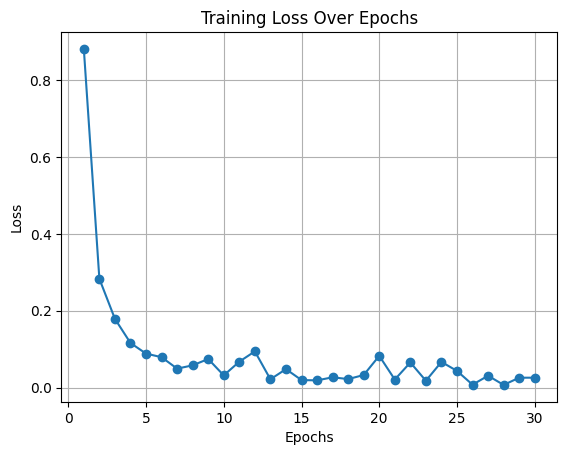

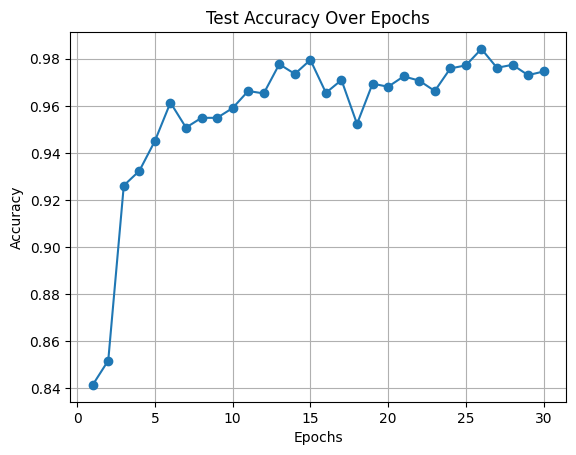

In [ ]:
#loss curve
plt.plot(range(1, len(trainLosses) + 1), trainLosses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
#saves based on modality used
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "trainLoss_RGB.png"))
else:
    plt.savefig(os.path.join(saveResults, "trainLoss_Thermal.png"))
plt.show()

#accuracy
plt.plot(range(1, len(testAccuracies) + 1), testAccuracies, marker='o')
plt.title("Test Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
#saves based on modality used
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "testAccuracy_RGB.png"))
else:
    plt.savefig(os.path.join(saveResults, "testAccuracy_Thermal.png"))
plt.show()


Classification Report:
              precision    recall  f1-score   support

       Angry       0.98      0.98      0.98       780
     Disgust       0.99      1.00      0.99       221
        Fear       0.98      0.96      0.97       346
       Happy       0.97      0.96      0.97      1125
     Neutral       1.00      0.98      0.99       103
         Sad       0.98      0.99      0.98       803
   Surprised       0.96      0.96      0.96       480

    accuracy                           0.97      3858
   macro avg       0.98      0.98      0.98      3858
weighted avg       0.97      0.97      0.97      3858



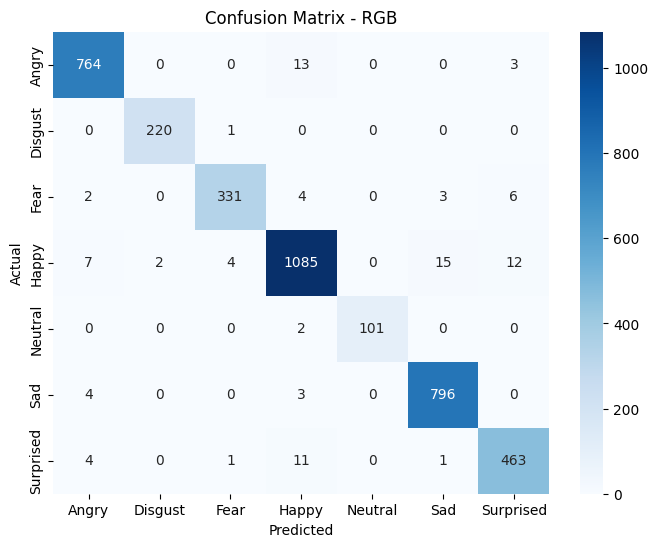

In [ ]:
# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(targetsArr, predictionsArr)
report = classification_report(targetsArr, predictionsArr, target_names=classNames)

print("\nClassification Report:")
print(report)

# Save classification report
if savingLabel == "RGB":
    with open(os.path.join(saveResults, "classificationReport_RGB.txt"), "w") as f:
        f.write(report)
elif savingLabel == "Thermal":
    with open(os.path.join(saveResults, "classificationReport_Thermal.txt"), "w") as f:
        f.write(report)
else:
    with open(os.path.join(saveResults, "classificationReport_MultiModal_EarlyFusion.txt"), "w") as f:
        f.write(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt="d",
            xticklabels=classNames,
            yticklabels=classNames,
            cmap="Blues")

plt.title(f"Confusion Matrix - {savingLabel}")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Save confusion matrix
if savingLabel == "RGB":
    plt.savefig(os.path.join(saveResults, "confusionMatrix_RGB.png"), bbox_inches="tight")
elif savingLabel == "Thermal":
    plt.savefig(os.path.join(saveResults, "confusionMatrix_Thermal.png"), bbox_inches="tight")
else:
    plt.savefig(os.path.join(saveResults, "confusionMatrix_MultiModal_EarlyFusion.png"), bbox_inches="tight")

plt.show()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


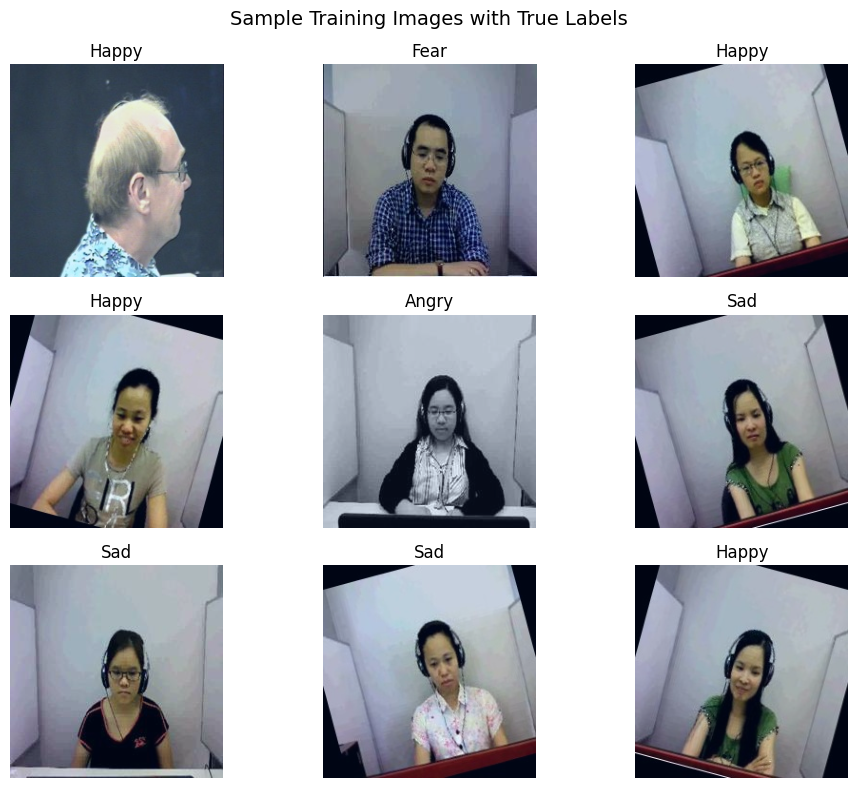

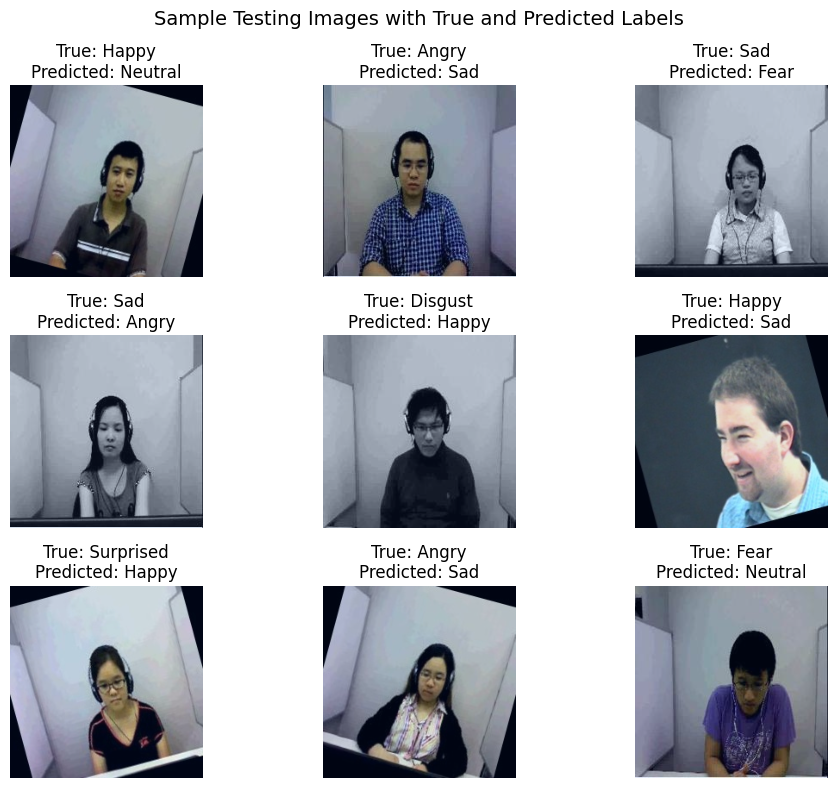

In [ ]:
#visualising some images and their labels

#true images and labels
imagesPlot, labelsPlot = next(iter(train_loader))

fig = plt.figure(figsize=(10, 8))
for i in range(3*3):

    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(imagesPlot[i].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))
    ax.set_title(classNames[labelsPlot[i]])
    ax.axis('off')
    plt.suptitle('Sample Training Images with True Labels',fontsize=14)
plt.tight_layout()


#predicted images and labels
imagesPlotPred, labelsPlotPred = next(iter(test_loader))

fig = plt.figure(figsize=(10, 8))
for i in range(3*3):

    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(np.transpose(torchvision.utils.make_grid(imagesPlotPred[i].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))

    trueLabel = classNames[labelsPlotPred[i]]
    predictedLabel = classNames[predicted[i]]

    ax.set_title(f'True: {trueLabel}\nPredicted: {predictedLabel}')
    ax.axis("off")
    plt.suptitle('Sample Testing Images with True and Predicted Labels',fontsize=14)
plt.tight_layout()